In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configuración visual para los gráficos
sns.set_style("whitegrid")
pd.set_option('display.max_columns', None) # Para ver todas las columnas

In [2]:
# ==========================================
# CONFIGURACIÓN DE RUTAS
# ==========================================
# Asegúrate de que estos nombres coincidan EXACTAMENTE con tus carpetas
RUTAS = {
    "MATRIMONIOS": "./data_matrimonios",
    "DIVORCIOS":   "./data_divorcios"
}

# Verificación automática de rutas
print("--- Verificando rutas ---")
for nombre, ruta in RUTAS.items():
    if os.path.exists(ruta):
        print(f" Encontrado: {nombre} -> {ruta}")
    else:
        print(f" ERROR: No se encuentra la carpeta para {nombre}: {ruta}")
        # Intenta mostrar qué hay en la carpeta superior para ayudar a depurar
        try:
            padre = os.path.dirname(ruta)
            contenido = os.listdir(padre)
            print(f"   Contenido de '{padre}': {contenido}")
        except:
            print("   No se pudo leer la carpeta superior.")

--- Verificando rutas ---
 Encontrado: MATRIMONIOS -> ./data_matrimonios
 Encontrado: DIVORCIOS -> ./data_divorcios


In [3]:
def cargar_dataset_ine(ruta_carpeta):
    archivos_sav = [f for f in os.listdir(ruta_carpeta) if f.endswith('.sav')]
    
    if not archivos_sav:
        print(f"⚠️  No hay archivos .sav en {ruta_carpeta}")
        return None

    lista_dfs = []
    
    # DICCIONARIO DE RENOMBRE
    # Agrega aquí las variaciones de nombres que encuentres en los diferentes años
    mapa_columnas = {
        'A_OCUR': 'ANIO_OCURRENCIA',
        'MES_OCUR': 'MES_OCURRENCIA',
        'DEPTO': 'DEPARTAMENTO',
        'MUN': 'MUNICIPIO',
        'SEXO': 'SEXO',
        'EDAD': 'EDAD',
        # Agrega más si el INE cambió nombres (ej. PUEBLO vs PUEBLOPERTENECE)
    }

    print(f"Iniciando carga de {len(archivos_sav)} archivos en: {ruta_carpeta}...")
    
    for archivo in archivos_sav:
        full_path = os.path.join(ruta_carpeta, archivo)
        try:
            # Leer archivo SPSS
            df_temp = pd.read_spss(full_path, convert_categoricals=False)
            
            # Estandarizar nombres
            df_temp.rename(columns=mapa_columnas, inplace=True)
            
            # Marcar origen
            df_temp['ARCHIVO_ORIGEN'] = archivo
            lista_dfs.append(df_temp)
            
        except Exception as e:
            print(f"    Error en {archivo}: {e}")

    if lista_dfs:
        df_unificado = pd.concat(lista_dfs, ignore_index=True)
        # Limpiar códigos de "Ignorado" (99, 999) a NaN
        df_unificado.replace([99, 999, 9999], np.nan, inplace=True)
        print(f" Carga completada. Total filas: {len(df_unificado)}")
        return df_unificado
    return None

def reporte_rapido(df, titulo):
    if df is None: return
    print(f"\n=== {titulo} ===")
    print(f"Dimensiones: {df.shape}")
    print("\n--- Variables Numéricas (Estadísticas) ---")
    print(df.describe().T[['mean', 'min', '50%', 'max', 'std']])
    print("\n--- Variables Categóricas (Top Frecuencias) ---")
    # Busca columnas con pocos valores únicos (asumiendo son categorías)
    for col in df.columns:
        if df[col].nunique() < 20 and df[col].dtype == 'object':
             print(f"\nVariable: {col}")
             print(df[col].value_counts(normalize=True).head()*100)

In [4]:
# Cargar Matrimonios
print("--- Cargando MATRIMONIOS ---")
df_matrimonios = cargar_dataset_ine(RUTAS["MATRIMONIOS"])

# Cargar Divorcios
print("\n--- Cargando DIVORCIOS ---")
df_divorcios = cargar_dataset_ine(RUTAS["DIVORCIOS"])

--- Cargando MATRIMONIOS ---
Iniciando carga de 9 archivos en: ./data_matrimonios...
 Carga completada. Total filas: 695853

--- Cargando DIVORCIOS ---
Iniciando carga de 11 archivos en: ./data_divorcios...
 Carga completada. Total filas: 60381



=== ANÁLISIS DE MATRIMONIOS ===
Dimensiones: (695853, 24)

--- Variables Numéricas (Estadísticas) ---
                 mean     min     50%     max        std
DEPREG       9.640197     1.0    10.0    22.0   6.369665
MESREG       6.523718     1.0     6.0    12.0   3.587695
AÑOREG    2018.646481  2015.0  2019.0  2023.0   2.850509
AÑOOCU    2018.558378  2015.0  2019.0  2022.0   2.837508
CLAUNI       2.926770     1.0     3.0     9.0   0.761728
NUNUHO       6.400503     1.0     9.0     9.0   3.742947
NUNUMU       6.388135     1.0     9.0     9.0   3.749067
EDADHOM     29.905528    14.0    26.0    98.0  11.334183
EDADMUJ     26.937052    12.0    24.0    95.0   9.923332
PUEHOM       3.263426     1.0     4.0     9.0   2.113271
PUEMUJ       3.463996     1.0     4.0     9.0   2.315935
NACHOM     322.058254     8.0   320.0  1043.0  34.001317
NACMUJ     321.661348     8.0   320.0  1043.0  31.261498
ESCHOM       2.990037     1.0     3.0     9.0   1.482818
ESCMUJ       3.014638     1.0     3.0     

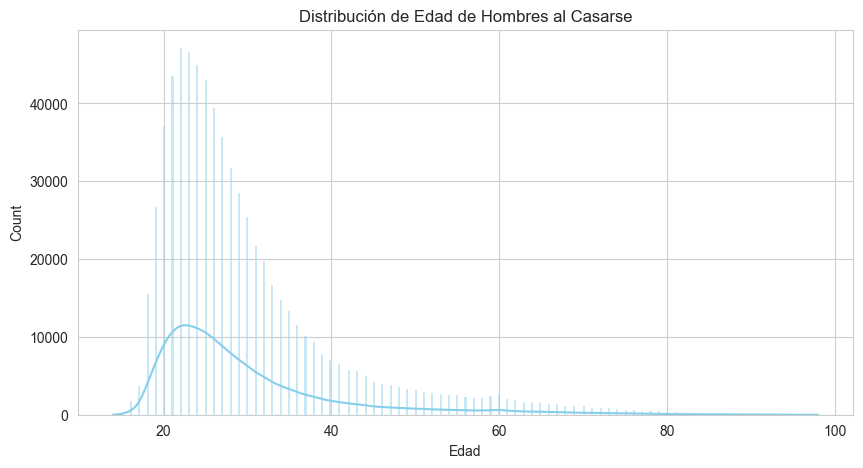

In [5]:
if df_matrimonios is not None:
    reporte_rapido(df_matrimonios, "ANÁLISIS DE MATRIMONIOS")
    
    col_edad = 'EDADHOM' if 'EDADHOM' in df_matrimonios.columns else 'EDAD_HOMBRE' 
    
    if col_edad in df_matrimonios.columns:
        plt.figure(figsize=(10, 5))
        sns.histplot(df_matrimonios[col_edad].dropna(), kde=True, color='skyblue')
        plt.title(f'Distribución de Edad de Hombres al Casarse')
        plt.xlabel('Edad')
        plt.show()
    else:
        print(f"⚠️ No encontré la columna '{col_edad}'. Revisa df_matrimonios.columns")

In [6]:
if df_divorcios is not None:
    reporte_rapido(df_divorcios, "ANÁLISIS DE DIVORCIOS")
    
    # Gráfico de barras por Departamento (Ejemplo)
    if 'DEPARTAMENTO' in df_divorcios.columns:
        plt.figure(figsize=(12, 6))
        # Top 10 departamentos con más divorcios
        top_deptos = df_divorcios['DEPARTAMENTO'].value_counts().head(10).index
        sns.countplot(data=df_divorcios[df_divorcios['DEPARTAMENTO'].isin(top_deptos)], 
                      x='DEPARTAMENTO', order=top_deptos, palette='viridis')
        plt.title('Top 10 Departamentos con más Divorcios')
        plt.xticks(rotation=45)
        plt.show()


=== ANÁLISIS DE DIVORCIOS ===
Dimensiones: (60381, 41)

--- Variables Numéricas (Estadísticas) ---
                 mean     min     50%     max        std
DEPREG       7.692387     1.0     5.0    22.0   7.099413
MESREG       6.565161     1.0     7.0    12.0   3.342646
AÑOREG    2015.222868  2015.0  2015.0  2016.0   0.416174
DIAOCU      16.084431     1.0    16.0    31.0   8.621187
MESOCU       6.260678     1.0     6.0    12.0   3.220650
AÑOOCU    2015.000000  2015.0  2015.0  2015.0   0.000000
DEPOCU       7.957056     1.0     6.0    22.0   7.100737
EDADHOM     34.799763    18.0    33.0    90.0  10.200980
EDADMUJ     31.362603    16.0    30.0    74.0   9.283256
PUEHOM       6.824136     1.0     9.0     9.0   2.754181
PUEMUJ       6.792176     1.0     9.0     9.0   2.749319
NACHOM     322.494211    32.0   320.0  1043.0  39.706128
NACMUJ     322.181898    32.0   320.0  1026.0  41.578875
ESCHOM       6.083130     1.0     9.0     9.0   3.191836
ESCMUJ       6.040517     1.0     9.0     9.0

In [7]:
# Imprimir todos los nombres de columnas para encontrarlas
print("--- Lista de Columnas en Divorcios ---")
print(df_divorcios.columns.tolist())

--- Lista de Columnas en Divorcios ---
['DEPREG', 'MUPREG', 'MESREG', 'AÑOREG', 'DIAOCU', 'MESOCU', 'AÑOOCU', 'DEPOCU', 'MUPOCU', 'EDADHOM', 'EDADMUJ', 'PUEHOM', 'PUEMUJ', 'NACHOM', 'NACMUJ', 'ESCHOM', 'ESCMUJ', 'CIUOHOM', 'CIUOMUJ', 'ARCHIVO_ORIGEN', 'AREAG', 'SEXO', 'TIPAR', 'CLAPAR', 'VIAPAR', 'SEMGES', 'EDADM', 'PAISREM', 'DEPREM', 'MUPREM', 'PUEBLOPM', 'ESCIVM', 'NACIONM', 'ESCOLAM', 'CIUOMAD', 'CAUDEF', 'ASISREC', 'SITIOOCU', 'TOHITE', 'TOHINM', 'TOHIVI']


In [8]:
# =============================================================================
# 1. LIMPIEZA Y PREPARACIÓN DE DATOS 
# =============================================================================

# Definimos las columnas exactas que encontraste
col_hombre = 'EDADHOM'
col_mujer = 'EDADMUJ'
col_anio = 'AÑOOCU'
col_depto = 'DEPOCU'

# Creamos una copia para trabajar seguros
df_clean = df_divorcios.copy()

# 1. Asegurar que las edades sean números (a veces vienen como texto)
df_clean[col_hombre] = pd.to_numeric(df_clean[col_hombre], errors='coerce')
df_clean[col_mujer] = pd.to_numeric(df_clean[col_mujer], errors='coerce')

# 2. Eliminar filas donde no hay edad (nulos)
df_clean = df_clean.dropna(subset=[col_hombre, col_mujer])

# 3. Crear variable: DIFERENCIA DE EDAD
df_clean['DIFERENCIA_EDAD'] = abs(df_clean[col_hombre] - df_clean[col_mujer])

# 4. Crear variable: RANGO DE EDAD 
bins = [0, 20, 30, 40, 50, 60, 100]
labels = ['<20', '20-29', '30-39', '40-49', '50-59', '60+']
df_clean['RANGO_EDAD_HOMBRE'] = pd.cut(df_clean[col_hombre], bins=bins, labels=labels)

print(f" Datos listos. Filas limpias: {len(df_clean)}")
print(df_clean[[col_hombre, col_mujer, 'DIFERENCIA_EDAD']].head())

 Datos listos. Filas limpias: 23300
    EDADHOM  EDADMUJ  DIFERENCIA_EDAD
2      46.0     40.0              6.0
68     40.0     39.0              1.0
69     50.0     41.0              9.0
72     28.0     28.0              0.0
73     21.0     20.0              1.0


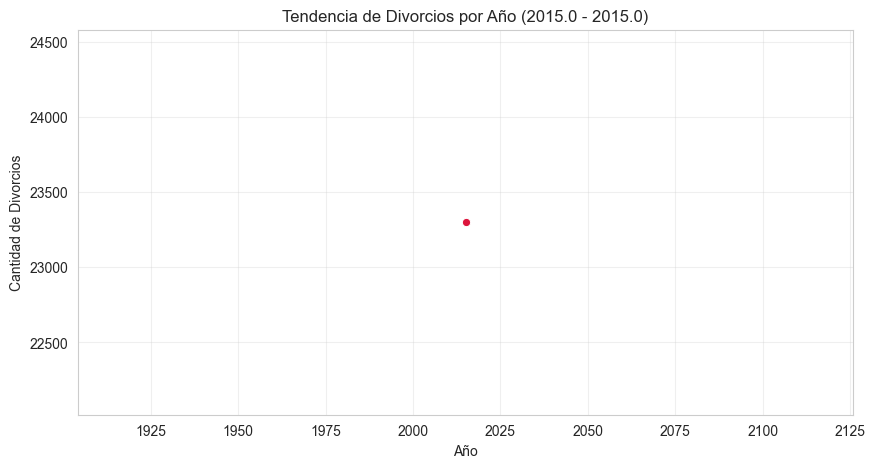

C:\Users\Virus\AppData\Local\Temp\ipykernel_8628\3731837697.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_deptos.index, y=top_deptos.values, palette='viridis')


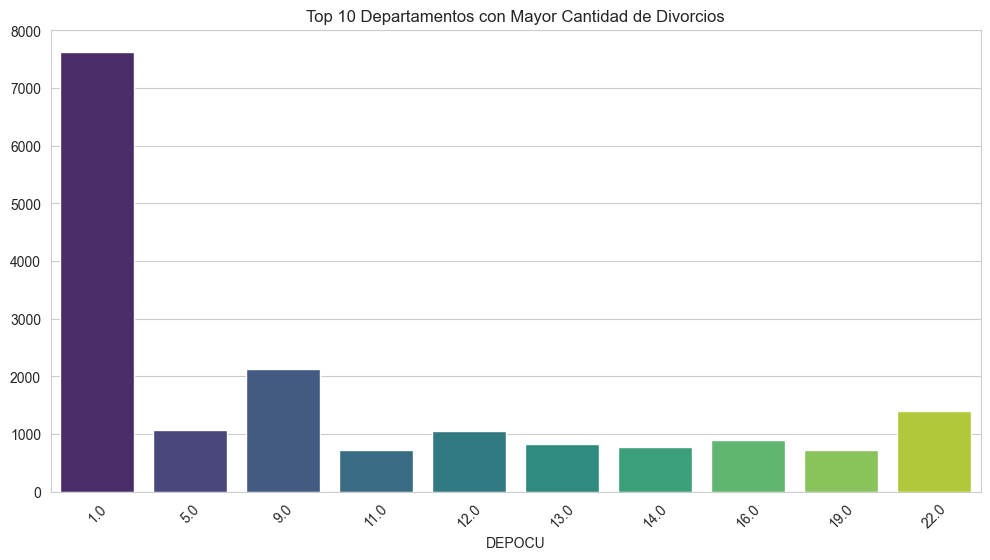

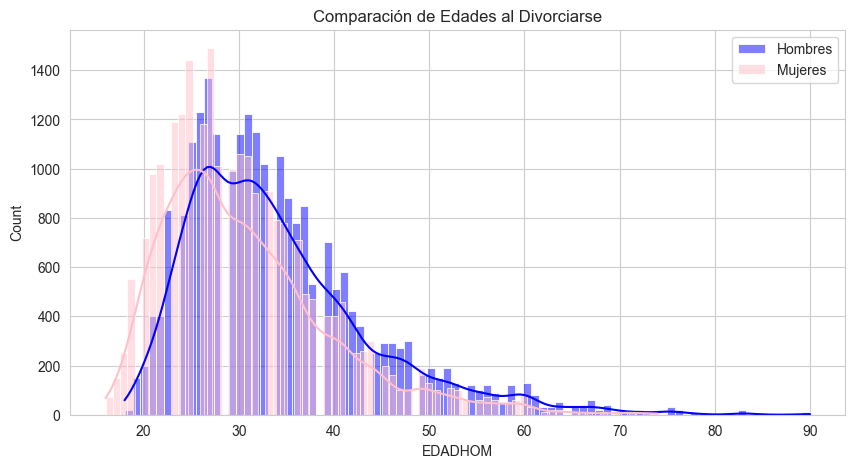

In [9]:
# =============================================================================
# 2. VALIDACIÓN DE HIPÓTESIS
# =============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# --- HIPÓTESIS TEMPORAL: ¿Aumentan los divorcios por año? ---
plt.figure(figsize=(10, 5))
conteo_anual = df_clean[col_anio].value_counts().sort_index()
sns.lineplot(x=conteo_anual.index, y=conteo_anual.values, marker='o', color='crimson')
plt.title(f'Tendencia de Divorcios por Año ({conteo_anual.index.min()} - {conteo_anual.index.max()})')
plt.xlabel('Año')
plt.ylabel('Cantidad de Divorcios')
plt.grid(True, alpha=0.3)
plt.show()

# --- HIPÓTESIS GEOGRÁFICA: ¿Qué departamentos tienen más divorcios? ---
plt.figure(figsize=(12, 6))
# Top 10 Departamentos
top_deptos = df_clean[col_depto].value_counts().head(10)
sns.barplot(x=top_deptos.index, y=top_deptos.values, palette='viridis')
plt.xticks(rotation=45)
plt.title('Top 10 Departamentos con Mayor Cantidad de Divorcios')
plt.show()

# --- HIPÓTESIS DE EDAD: Distribución de edades ---
plt.figure(figsize=(10, 5))
sns.histplot(df_clean[col_hombre], color='blue', alpha=0.5, label='Hombres', kde=True)
sns.histplot(df_clean[col_mujer], color='pink', alpha=0.5, label='Mujeres', kde=True)
plt.legend()
plt.title('Comparación de Edades al Divorciarse')
plt.show()

In [ ]:
# =============================================================================
# 3. CLUSTERING (Agrupamiento)
# =============================================================================
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

features = [col_hombre, col_mujer, 'DIFERENCIA_EDAD']
X = df_clean[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

inercias = []
rango_k = range(1, 8)
for k in rango_k:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inercias.append(kmeans.inertia_)

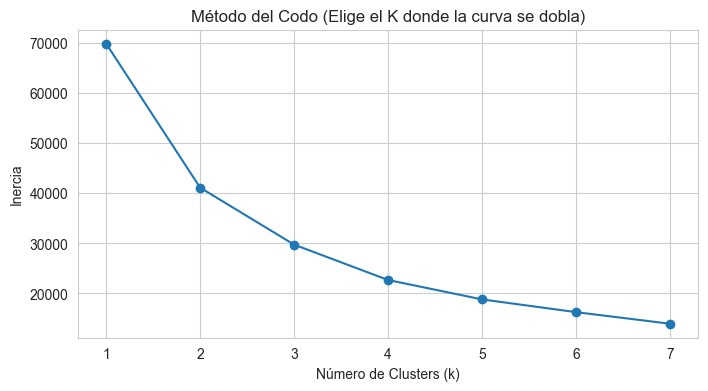

In [16]:
# Gráfico del Codo
plt.figure(figsize=(8, 4))
plt.plot(rango_k, inercias, marker='o')
plt.title('Método del Codo (Elige el K donde la curva se dobla)')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.show()


In [ ]:

k_final = 3 
kmeans_model = KMeans(n_clusters=k_final, random_state=42, n_init=10)
df_clean['CLUSTER'] = kmeans_model.fit_predict(X_scaled)

print("\n--- CARACTERÍSTICAS DE LOS GRUPOS ENCONTRADOS ---")
print(df_clean.groupby('CLUSTER')[features].mean())



--- CARACTERÍSTICAS DE LOS GRUPOS ENCONTRADOS ---
           EDADHOM    EDADMUJ  DIFERENCIA_EDAD
CLUSTER                                       
0        45.862434  30.809524        17.698413
1        45.608863  43.161850         4.292871
2        29.136252  26.696671         3.582614


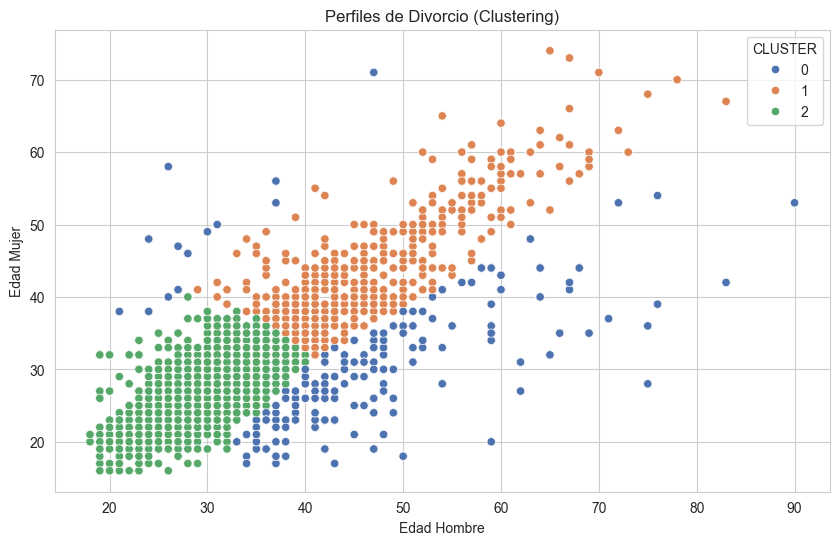

In [ ]:
# Visual de los Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_clean, x=col_hombre, y=col_mujer, hue='CLUSTER', palette='deep')
plt.title('Perfiles de Divorcio (Clustering)')
plt.xlabel('Edad Hombre')
plt.ylabel('Edad Mujer')
plt.show()